In [2]:
from karabo.imaging.imager import Imager
from karabo.simulation.telescope import Telescope
from karabo.simulation.observation import Observation
from karabo.simulation.interferometer import InterferometerSimulation
from karabo.simulation.sky_model import SkyModel
from karabo.sourcedetection.result import (
    PyBDSFSourceDetectionResult,
)
from karabo.sourcedetection.evaluation import SourceDetectionEvaluation
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr 
# Render plots inline
%matplotlib inline

The RASCIL data directory is not available - continuing but any simulations will fail


In [3]:
import copy
import enum
import logging
import math
from typing import Any, Callable, Dict, List, Literal, Optional, Tuple, Union, cast
from warnings import warn

import dask.array as da
import h5py
import matplotlib.pyplot as plt
import numpy as np
import oskar
import pandas as pd
import xarray as xr
from astropy import units as u
from astropy.io import fits
from astropy.table import Table
from astropy.visualization.wcsaxes import SphericalCircle
from astropy.wcs import WCS

## Simulation

/home/vincenzo/Karabo-Pipeline/karabo/simulation/sky_model.py:626: KaraboWarning: Warning: flux with value <= 0 found, setting those to np.nan to avoid logarithmic errors (only affects the colorbar)
  warn(


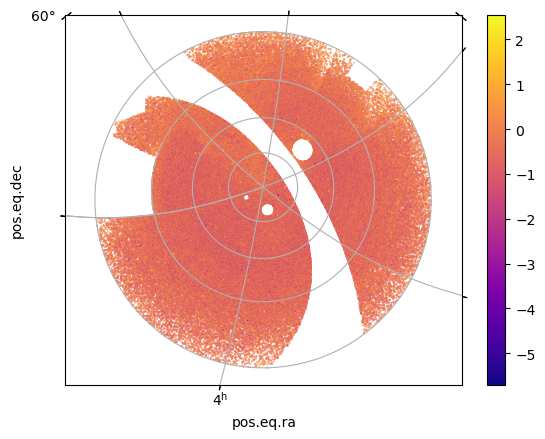

In [4]:
# Get GLEAM Survey Sky
phase_center = [250, -80]
gleam_sky = SkyModel.get_GLEAM_Sky([76])
gleam_sky.explore_sky(phase_center, s=0.1)

Then we filter the sky model based on radius.

In [5]:
sky = gleam_sky.filter_by_radius(0, 0.55, phase_center[0], phase_center[1])
sky.setup_default_wcs(phase_center=phase_center)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---AIR'  'DEC--AIR'  
CRVAL : 250.0  -80.0  
CRPIX : 0.0  0.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -1.0  1.0  
NAXIS : 0  0

In [6]:
gleam_sky.sources

<xarray.DataArray (source_name: 307455, columns: 12)>
dask.array<transpose, shape=(307455, 12), dtype=float64, chunksize=(307455, 12), chunktype=numpy.ndarray>
Coordinates:
  * source_name  (source_name) <U14 'J235139-894114' ... 'J133637-335724'
Dimensions without coordinates: columns

Let's have a closer look with the 2d image project explore_sky() provides.

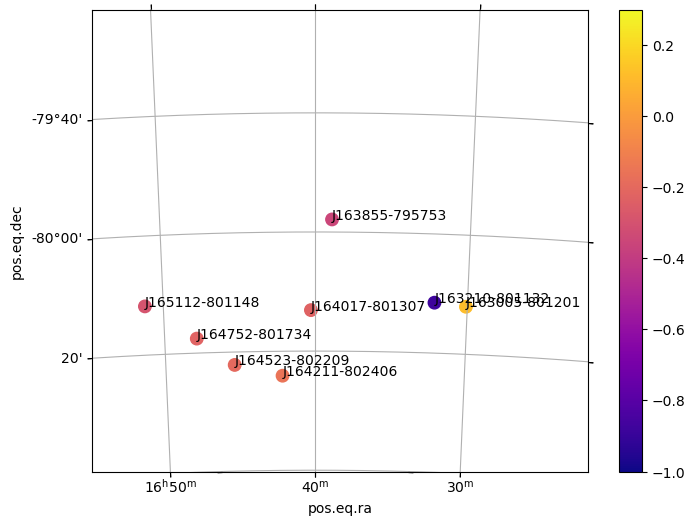

In [7]:
sky.explore_sky(
    phase_center=phase_center,
    figsize=(8, 6),
    xlim=(254, 246),  # RA-lim
    ylim=(-81, -79),  # DEC-lim
    with_labels=True,
    s=80,
    vmin=-1,
    vmax=0.3,
)

In [8]:
sky_specific_name = sky.sources[sky.sources.source_name == "J164752-801734"]

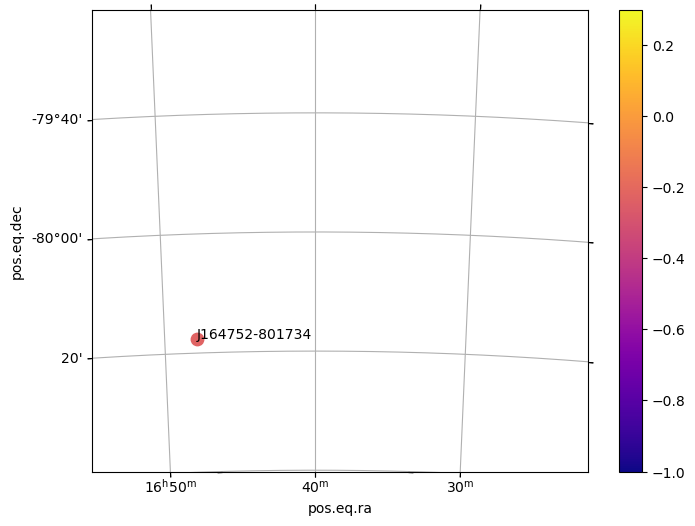

In [9]:
SkyModel(sky_specific_name).explore_sky(
    phase_center=phase_center,
    figsize=(8, 6),
    xlim=(254, 246),  # RA-lim
    ylim=(-81, -79),  # DEC-lim
    with_labels=True,
    s=80,
    vmin=-1,
    vmax=0.3,
)

### Telescope Module

Various observation parameters and meta information `params` must be passed to the telescope module `oskar.Interferometer` of OSKAR as `oskar.SettingsTree`.

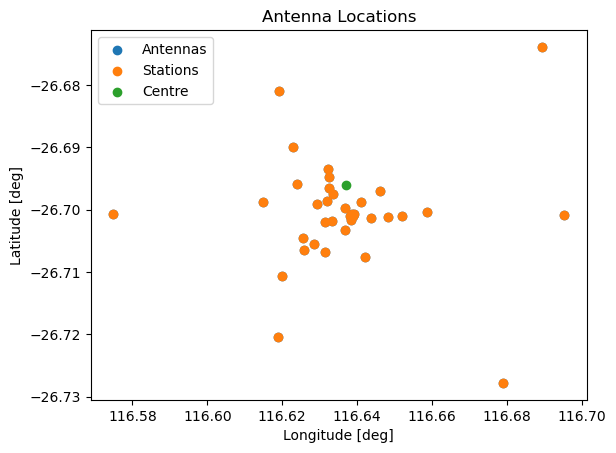

In [10]:
askap_tel = Telescope.get_ASKAP_Telescope()
askap_tel.plot_telescope()

### Observation Simulation

Now the sky module must be passed to the interferometer and the simulation of the observation must be started to generate the measurement set.

In [18]:
from karabo.simulation.visibility import Visibility

observation_settings = Observation(
    start_frequency_hz=100e6,
    phase_centre_ra_deg=phase_center[0],
    phase_centre_dec_deg=phase_center[1],
    number_of_channels=64,
    number_of_time_steps=24,
)

# If you want, you can define where karabo should store the visibilities
# If not, karabo will decide where to store it.
vis = Visibility()
vis_path = vis.file.path

print(f"Saving file to {vis_path}")
interferometer_sim = InterferometerSimulation(
    vis_path=vis_path,
    channel_bandwidth_hz=1e6
    )
visibility_askap = interferometer_sim.run_simulation(
    askap_tel, sky, observation_settings, 
)

Saving file to /home/vincenzo/Karabo-Pipeline/karabo/examples/karabo_folder/cfed90ce-54c7-497b-99d1-d29bab433b1a/visibility.vis
Parameter 'use_gpus' is None! Using function 'karabo.util.is_cuda_available()' to overwrite parameter 'use_gpu' to True.
Parameter 'use_dask' is None! Using function 'karabo.util.dask.DaskHandler.should_dask_be_used()' to overwrite parameter 'use_dask' to False.
W|                                                                   
W|== WARNING: Gaussian ellipse solution failed for 8 sources. These will be simulated as point sources.
W|                                                                   
/home/vincenzo/Karabo-Pipeline/karabo/examples/karabo_folder/cfed90ce-54c7-497b-99d1-d29bab433b1a/visibility.vis


### Dirty Images

We can create dirty images of visibilites and display them as shown below

In [19]:
imaging_npixel = 2048
imaging_cellsize = 3.878509448876288e-05

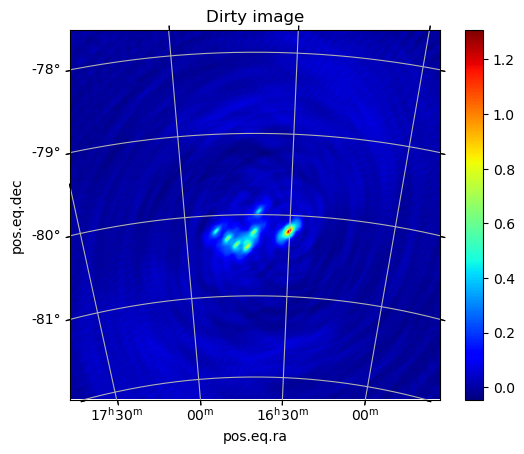

In [20]:
imager_askap = Imager(
    visibility_askap,
    imaging_npixel=imaging_npixel,
    imaging_cellsize=imaging_cellsize,
)
dirty = imager_askap.get_dirty_image()
dirty.plot(title="Dirty image")

### Source Detection

In [21]:
beam_guess = PyBDSFSourceDetectionResult.guess_beam_parameters(
    imager=imager_askap, method="rascil_1_iter"
)
detection_result_dirty = PyBDSFSourceDetectionResult.detect_sources_in_image(
    image=dirty, beam=beam_guess
)

--> Opened '/home/vincenzo/Karabo-Pipeline/karabo/examples/karabo_folder/742c6554-f6a6-4875-86f2-a893706880b9/dirty.fits'
Image size .............................. : (2048, 2048) pixels
Number of channels ...................... : 64
Number of Stokes parameters ............. : 1
Beam shape (major, minor, pos angle) .... : (1.09546e-01, 5.05037e-02, -43.6) degrees
--> Channels averaged with uniform weights
--> Source extraction will be done on averaged ("ch0") image
Frequency of averaged image ............. : 100.000 MHz
Number of blank pixels .................. : 0 (0.0%)
Flux from sum of (non-blank) pixels ..... : 53.201 Jy
--> Calculating background rms and mean images
Derived rms_box (box size, step size) ... : (1115, 205) pixels
--> Size of rms_box larger than 1/4 of image size
--> Using constant background rms and mean
Value of background rms ................. : 2.16e-02 Jy/beam
Value of background mean ................ : 0.00467 Jy/beam
--> Expected 5-sigma-clipped false detection

Fitting islands with Gaussians .......... : [|] 0/1Fitting islands with Gaussians .......... : [] 1/1[-3G

Total number of Gaussians fit to image .. : 13
Total flux density in model ............. : 11.561 Jy


--> Grouping Gaussians into sources
Number of sources formed from Gaussians   : 6


--> Wrote ASCII file '/home/vincenzo/Karabo-Pipeline/karabo/examples/karabo_folder/1952b87e-1e93-4f94-ac07-49e86376f60e/sources.csv'
--> Wrote file '/home/vincenzo/Karabo-Pipeline/karabo/examples/karabo_folder/363b743a-ad78-413d-b131-d1b7080f3dea/result.fits'


In [22]:
ground_truth, sky_idxs = Imager.project_sky_to_image(
    sky=sky,
    phase_center=phase_center,
    imaging_cellsize=imaging_cellsize,
    imaging_npixel=imaging_npixel,
    filter_outlier=True,
    invert_ra=True,
)

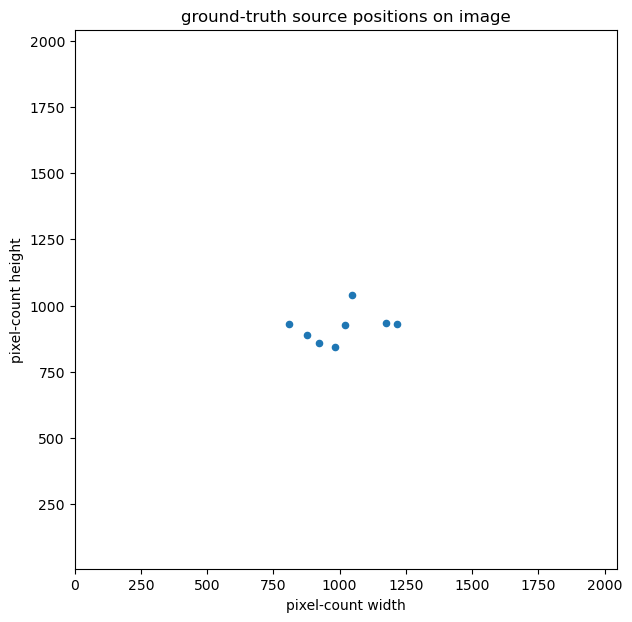

In [23]:
fig, ax = plt.subplots(
    figsize=(7, 7),
)
sc = ax.scatter(ground_truth[0], ground_truth[1], s=20)

# for idx, i in enumerate(range(ground_truth[0].shape[0])):
#     ax.annotate(sky[idx,-1], (ground_truth[0][i], ground_truth[1][i]))

plt.axis("equal")
plt.title("ground-truth source positions on image")
plt.xlim((0, imaging_npixel))
plt.ylim((0, imaging_npixel))
plt.xlabel("pixel-count width")
plt.ylabel("pixel-count height")
plt.show()

In [24]:
assignments_dirty = (
    SourceDetectionEvaluation.automatic_assignment_of_ground_truth_and_prediction(
        ground_truth=ground_truth.T,
        detected=detection_result_dirty.get_pixel_position_of_sources().T,
        max_dist=10,
        top_k=3,
    )
)
assignments_dirty

array([[-1.        ,  0.        ,         inf],
       [-1.        ,  2.        ,         inf],
       [-1.        ,  3.        ,         inf],
       [-1.        ,  9.        ,         inf],
       [-1.        , 10.        ,         inf],
       [-1.        , 11.        ,         inf],
       [ 0.        ,  7.        ,  2.72404777],
       [ 1.        ,  5.        ,  5.14388278],
       [ 2.        ,  8.        ,  3.89535742],
       [ 3.        ,  1.        ,  3.06498172],
       [ 4.        ,  4.        ,  1.05390316],
       [ 5.        , -1.        ,         inf],
       [ 6.        , 12.        ,  3.11399477],
       [ 7.        ,  6.        ,  2.15996229]])

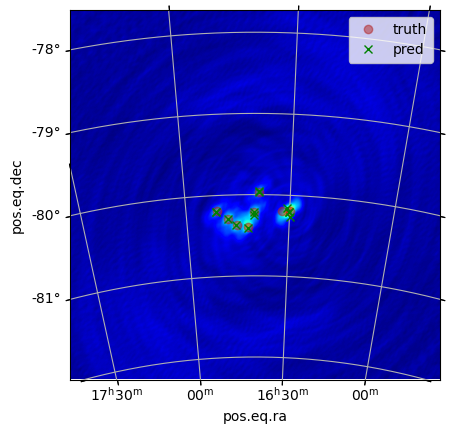

In [25]:
sde_dirty = SourceDetectionEvaluation(
    sky=sky,
    ground_truth=ground_truth,
    assignments=assignments_dirty,
    sky_idxs=sky_idxs,
    source_detection=detection_result_dirty,
)
sde_dirty.plot()

### Imaging
Of course, we can also do source detection on cleaned (clean algorithmus by rascil) images.

In [26]:
imager_askap.ingest_chan_per_blockvis = 1
imager_askap.ingest_vis_nchan = 16

# Try differnet algorithm
# More sources
deconvolved, restored, residual = imager_askap.imaging_rascil(
    clean_nmajor=0,
    clean_algorithm="mmclean",
    clean_scales=[0, 6, 10, 30, 60],
    clean_fractional_threshold=0.3,
    clean_threshold=0.12e-3,
    clean_nmoment=5,
    clean_psf_support=640,
    clean_restored_output="integrated",
)

## Analysis via Source Detection

Source Detection on restored image.

In [27]:
detection_result = PyBDSFSourceDetectionResult.detect_sources_in_image(restored)

--> Opened '/home/vincenzo/Karabo-Pipeline/karabo/examples/karabo_folder/85730e02-085d-4884-884e-57706ebd3275/restored.fits'
Image size .............................. : (2048, 2048) pixels
Number of channels ...................... : 1
Number of Stokes parameters ............. : 1
Beam shape (major, minor, pos angle) .... : (1.09546e-01, 5.05037e-02, -943.6) degrees
Frequency of image ...................... : 100.000 MHz
Number of blank pixels .................. : 0 (0.0%)
Flux from sum of (non-blank) pixels ..... : 21.860 Jy
--> Calculating background rms and mean images
Derived rms_box (box size, step size) ... : (1221, 205) pixels
--> Size of rms_box larger than 1/4 of image size
--> Using constant background rms and mean
Value of background rms ................. : 8.62e-03 Jy/beam
Value of background mean ................ : 0.00197 Jy/beam
--> Expected 5-sigma-clipped false detection rate < fdr_ratio
--> Using sigma-clipping ('hard') thresholding
Minimum number of pixels per island 

Fitting islands with Gaussians .......... : [|] 0/2/Fitting islands with Gaussians .......... : [/] 1/2Fitting islands with Gaussians .......... : [] 2/2[-3GFitting islands with Gaussians .......... : [] 2/2[-3G

Total number of Gaussians fit to image .. : 30
Total flux density in model ............. : 9.916 Jy


--> Grouping Gaussians into sources
Number of sources formed from Gaussians   : 6


--> Wrote ASCII file '/home/vincenzo/Karabo-Pipeline/karabo/examples/karabo_folder/145f24bc-27e0-4878-9cae-7fbceecbbf05/sources.csv'
--> Wrote file '/home/vincenzo/Karabo-Pipeline/karabo/examples/karabo_folder/c085d23a-89d7-4812-96c6-aa40d2fa3481/result.fits'


## Evaluation

In [28]:
assignments_restored = (
    SourceDetectionEvaluation.automatic_assignment_of_ground_truth_and_prediction(
        ground_truth=ground_truth.T,
        detected=detection_result.get_pixel_position_of_sources().T,
        max_dist=15,
        top_k=3,
    )
)
assignments_restored

array([[-1.        , 15.        ,         inf],
       [-1.        , 20.        ,         inf],
       [-1.        , 19.        ,         inf],
       [-1.        , 18.        ,         inf],
       [-1.        , 17.        ,         inf],
       [-1.        , 16.        ,         inf],
       [-1.        , 29.        ,         inf],
       [-1.        , 14.        ,         inf],
       [-1.        , 13.        ,         inf],
       [-1.        , 12.        ,         inf],
       [-1.        , 21.        ,         inf],
       [-1.        , 11.        ,         inf],
       [-1.        ,  9.        ,         inf],
       [-1.        , 23.        ,         inf],
       [-1.        ,  7.        ,         inf],
       [-1.        , 25.        ,         inf],
       [-1.        , 26.        ,         inf],
       [-1.        , 27.        ,         inf],
       [-1.        ,  3.        ,         inf],
       [-1.        , 28.        ,         inf],
       [-1.        ,  1.        ,       

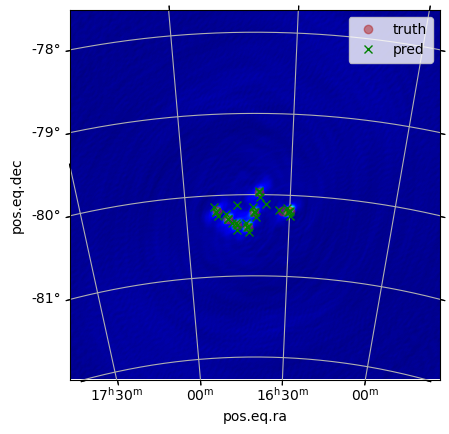

In [29]:
# Create mapping plots
sde_restored = SourceDetectionEvaluation(
    sky=sky,
    ground_truth=ground_truth,
    assignments=assignments_restored,
    sky_idxs=sky_idxs,
    source_detection=detection_result,
)
sde_restored.plot()

In [30]:
# Confusion Matrix
sde_restored.get_confusion_matrix()

array([[ 0., 23.],
       [ 1.,  7.]])

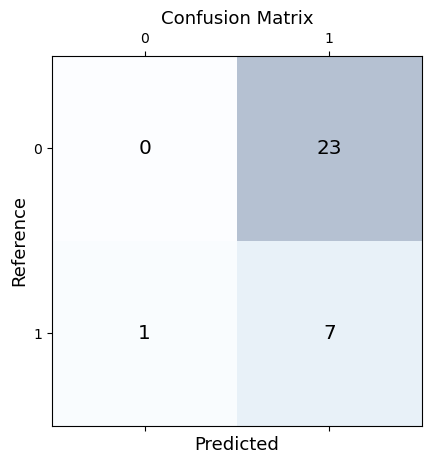

In [31]:
sde_restored.plot_confusion_matrix()

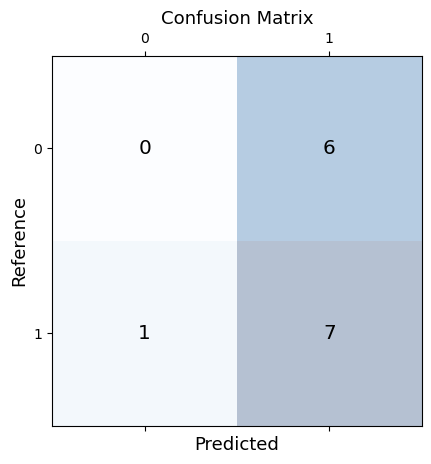

In [32]:
sde_dirty.plot_confusion_matrix()

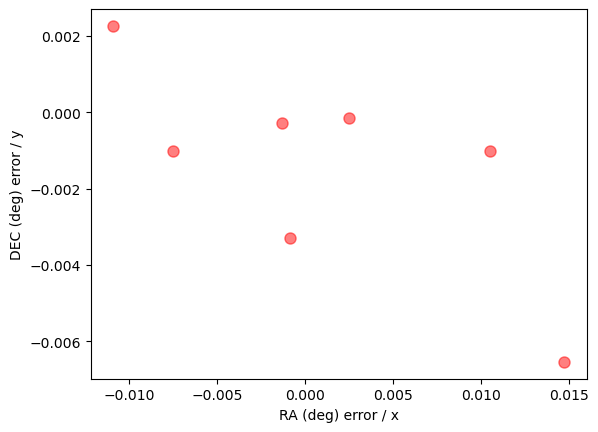

In [33]:
# Plot error ra and dec
sde_restored.plot_error_ra_dec()

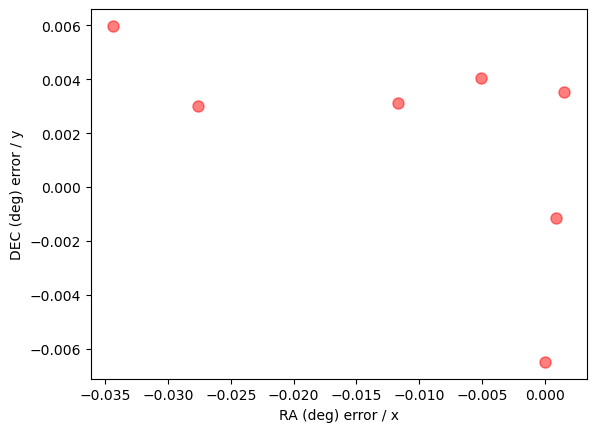

In [34]:
# Plot error ra and dec
sde_dirty.plot_error_ra_dec()

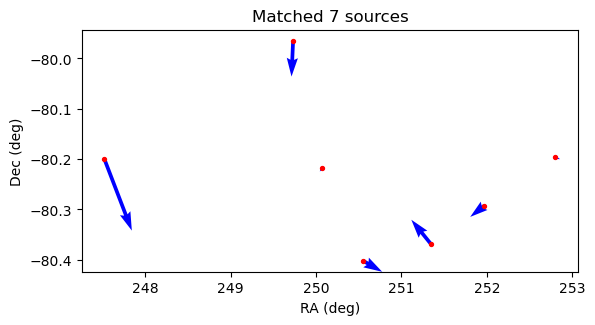

In [35]:
# Plot error flux
sde_restored.plot_quiver_positions()

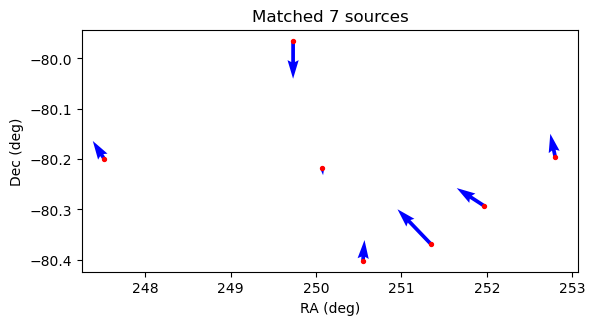

In [36]:
# Plot error flux
sde_dirty.plot_quiver_positions()

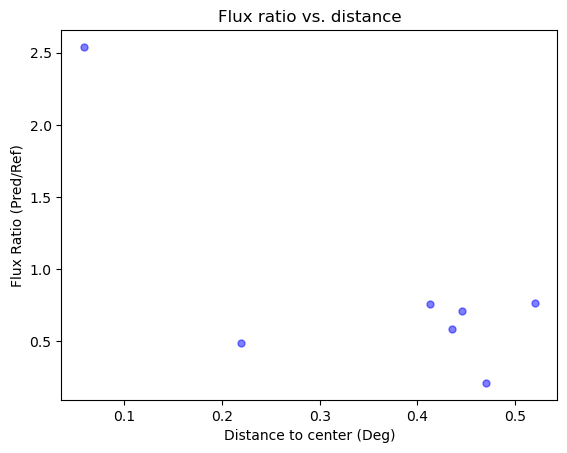

In [37]:
# Plot error ra and dec
sde_restored.plot_flux_ratio_to_distance()

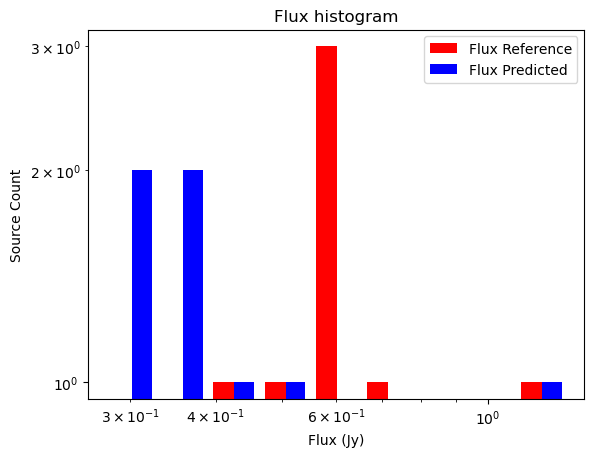

In [38]:
# Plot error ra and dec
sde_restored.plot_flux_histogram()

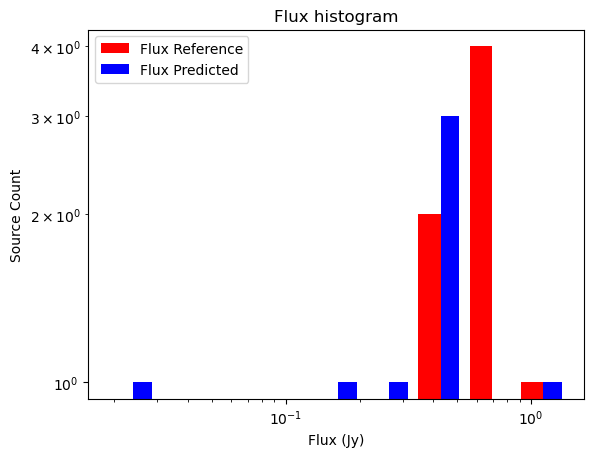

In [39]:
# Plot error ra and dec
sde_dirty.plot_flux_histogram()

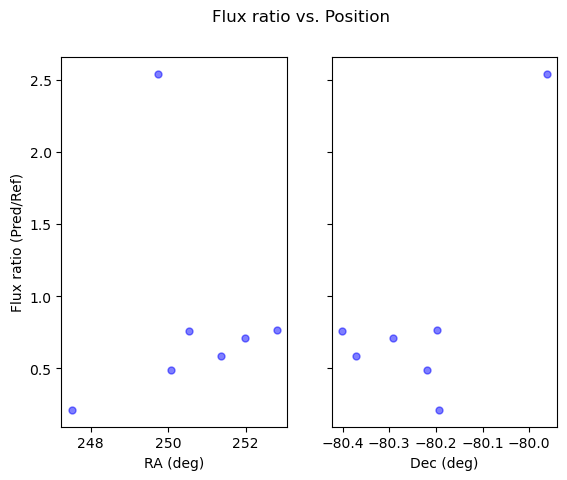

In [40]:
# Plot error ra and dec
sde_restored.plot_flux_ratio_to_ra_dec()

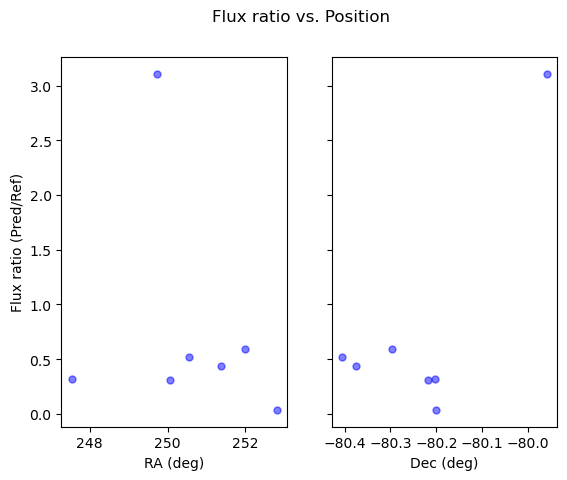

In [41]:
# Plot error ra and dec
sde_dirty.plot_flux_ratio_to_ra_dec()

In [42]:
from karabo.util.file_handle import FileHandle

# Clean up, if you want to
fh = FileHandle()
fh.clean_up()